# Summary of Broadcast between Nodes

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 30)

project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/inter_anode'
dir_vnode_results = f'{project_dir}/inter_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    if filepath.endswith('nccl'):
        is_nccl_file = True
    else:
        is_nccl_file = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            if is_nccl_file and line.startswith('['):
                continue
            lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    if is_nccl_file:
        data = [float(line.split()[4]) for line in lines]
    else:
        data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data():
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    methods = {
        'mpi-gpu': 'mpi',
        'mpi-cpu': 'mpi-cpu',
        'nccl': 'nccl'
    }
    nnodes = [2, 4, 8, 16, 32]

    series = []
    for method, suffix in methods.items():
        for node, dirpath in node_types.items():
            for nnode in nnodes:
                column_key = f'{method}:{node}:{nnode}'
                file_pattern = f'{dirpath}/job{nnode:02d}.sh.*.{suffix}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title, legend_fontsize=None):
    def _xticks_labels():
        idxs = [4, 8, 12, 16, 20, 24]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel('Time (Micro-second)')
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    ax.legend(fontsize=legend_fontsize)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,mpi-gpu:anode:2,mpi-gpu:anode:4,mpi-gpu:anode:8,mpi-gpu:anode:16,mpi-gpu:vnode:2,mpi-gpu:vnode:4,mpi-gpu:vnode:8,mpi-gpu:vnode:16,mpi-gpu:vnode:32,mpi-cpu:anode:2,mpi-cpu:anode:4,mpi-cpu:anode:8,mpi-cpu:anode:16,mpi-cpu:vnode:2,mpi-cpu:vnode:4,mpi-cpu:vnode:8,mpi-cpu:vnode:16,mpi-cpu:vnode:32,nccl:anode:2,nccl:anode:4,nccl:anode:8,nccl:anode:16,nccl:vnode:2,nccl:vnode:4,nccl:vnode:8,nccl:vnode:16,nccl:vnode:32
1,8.85,11.28,14.32,16.79,6.13,7.89,10.13,11.85,13.78,2.53,4.69,5.80,7.37,1.71,2.66,3.76,5.20,6.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12.60,14.73,17.55,20.05,7.92,9.65,11.95,13.69,15.68,2.51,4.08,5.63,7.22,1.73,2.76,3.83,5.12,6.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12.32,14.69,17.52,19.99,7.99,9.82,11.93,13.61,15.69,2.51,4.05,5.62,7.21,1.73,2.67,3.73,5.07,6.18,7.79,12.07,7.77,7.71,5.29,5.49,5.33,5.56,5.34
8,12.33,14.77,17.45,20.04,7.97,9.77,11.66,13.50,15.70,2.49,4.05,5.64,7.21,1.74,2.62,3.74,5.11,6.20,7.46,7.68,7.66,7.57,5.12,4.86,5.26,5.28,5.18
16,8.94,11.30,14.21,16.66,6.85,8.67,10.47,12.52,14.47,2.54,4.04,5.66,7.22,1.70,2.63,3.82,5.12,6.28,7.46,7.48,7.69,7.70,5.12,4.94,5.26,5.29,5.20
32,11.74,14.80,16.64,19.06,6.88,8.66,10.67,12.64,14.86,2.88,4.54,5.94,7.57,1.94,2.92,4.06,5.27,6.52,7.50,7.57,7.71,7.64,5.16,4.86,5.27,5.33,5.24
64,12.70,15.04,18.06,20.11,7.92,10.19,11.44,14.90,16.75,3.24,4.52,6.54,8.03,2.22,3.22,4.45,5.64,6.99,7.60,7.62,7.84,7.73,5.20,4.88,5.28,5.33,5.28
128,12.35,15.62,18.17,20.22,8.71,10.48,12.49,15.14,17.33,3.27,5.06,7.29,8.56,2.38,3.54,4.80,5.92,7.20,7.60,7.60,7.73,7.76,5.18,4.85,5.28,5.39,5.27
256,12.56,15.78,18.81,20.79,9.53,10.97,12.77,15.52,17.75,3.54,5.51,7.69,9.33,2.71,4.16,5.79,7.25,8.66,7.62,7.64,7.81,7.76,5.22,4.87,5.32,5.38,5.27
512,13.34,16.41,18.99,20.81,10.80,12.32,14.30,18.56,20.57,3.85,5.86,8.34,9.71,2.87,4.28,5.91,7.44,9.08,7.70,7.69,7.82,7.76,5.23,4.87,5.36,5.41,5.28


## Node(A) vs. Node(V)

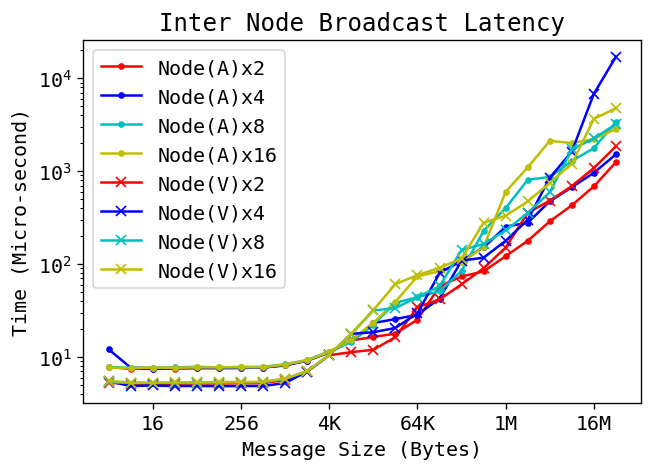

In [4]:
title = 'Inter Node Broadcast Latency'
column_labels = {
    'nccl:anode:2': 'Node(A)x2',
    'nccl:anode:4': 'Node(A)x4',
    'nccl:anode:8': 'Node(A)x8',
    'nccl:anode:16': 'Node(A)x16',
    'nccl:vnode:2': 'Node(V)x2',
    'nccl:vnode:4': 'Node(V)x4',
    'nccl:vnode:8': 'Node(V)x8',
    'nccl:vnode:16': 'Node(V)x16',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

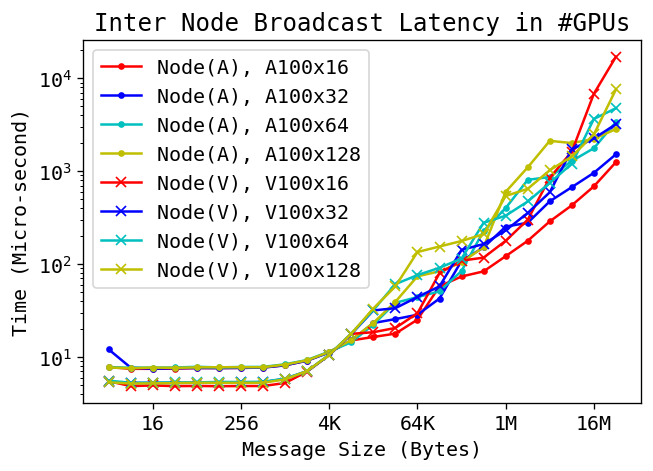

In [5]:
title = 'Inter Node Broadcast Latency in #GPUs'
column_labels = {
    'nccl:anode:2': 'Node(A), A100x16',
    'nccl:anode:4': 'Node(A), A100x32',
    'nccl:anode:8': 'Node(A), A100x64',
    'nccl:anode:16': 'Node(A), A100x128',
    'nccl:vnode:4': 'Node(V), V100x16',
    'nccl:vnode:8': 'Node(V), V100x32',
    'nccl:vnode:16': 'Node(V), V100x64',
    'nccl:vnode:32': 'Node(V), V100x128',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(A)

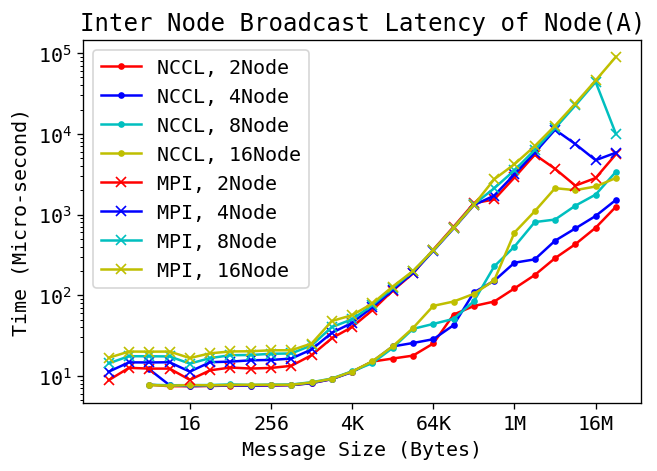

In [6]:
title = 'Inter Node Broadcast Latency of Node(A)'
column_labels = {
    'nccl:anode:2': 'NCCL, 2Node',
    'nccl:anode:4': 'NCCL, 4Node',
    'nccl:anode:8': 'NCCL, 8Node',
    'nccl:anode:16': 'NCCL, 16Node',
    'mpi-gpu:anode:2': 'MPI, 2Node',
    'mpi-gpu:anode:4': 'MPI, 4Node',
    'mpi-gpu:anode:8': 'MPI, 8Node',
    'mpi-gpu:anode:16': 'MPI, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

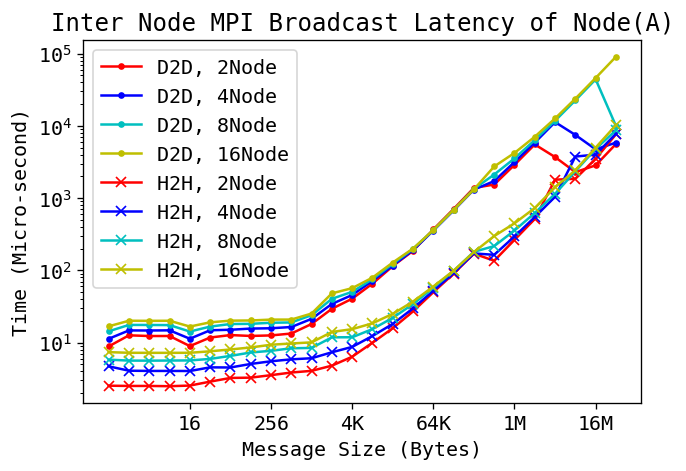

In [7]:
title = 'Inter Node MPI Broadcast Latency of Node(A)'
column_labels = {
    'mpi-gpu:anode:2': 'D2D, 2Node',
    'mpi-gpu:anode:4': 'D2D, 4Node',
    'mpi-gpu:anode:8': 'D2D, 8Node',
    'mpi-gpu:anode:16': 'D2D, 16Node',
    'mpi-cpu:anode:2': 'H2H, 2Node',
    'mpi-cpu:anode:4': 'H2H, 4Node',
    'mpi-cpu:anode:8': 'H2H, 8Node',
    'mpi-cpu:anode:16': 'H2H, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(V)

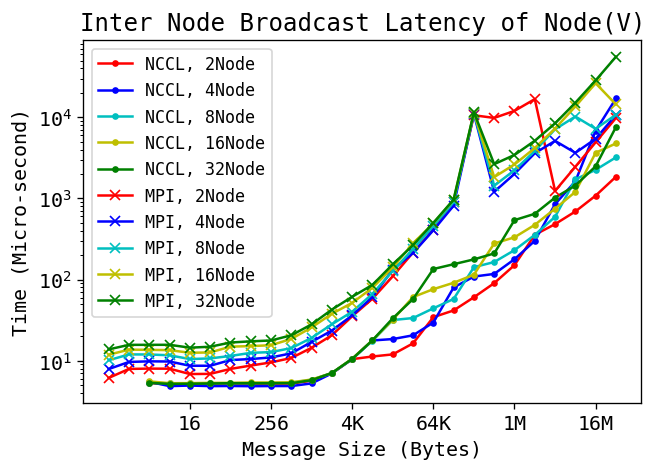

In [8]:
title = 'Inter Node Broadcast Latency of Node(V)'
column_labels = {
    'nccl:vnode:2': 'NCCL, 2Node',
    'nccl:vnode:4': 'NCCL, 4Node',
    'nccl:vnode:8': 'NCCL, 8Node',
    'nccl:vnode:16': 'NCCL, 16Node',
    'nccl:vnode:32': 'NCCL, 32Node',
    'mpi-gpu:vnode:2': 'MPI, 2Node',
    'mpi-gpu:vnode:4': 'MPI, 4Node',
    'mpi-gpu:vnode:8': 'MPI, 8Node',
    'mpi-gpu:vnode:16': 'MPI, 16Node',
    'mpi-gpu:vnode:32': 'MPI, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=10)

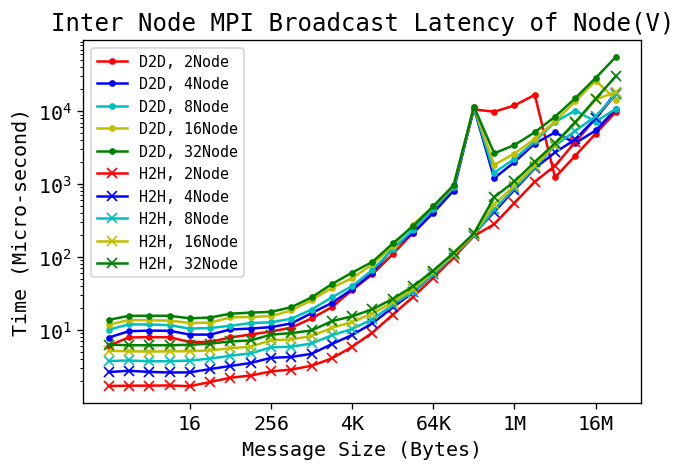

In [9]:
title = 'Inter Node MPI Broadcast Latency of Node(V)'
column_labels = {
    'mpi-gpu:vnode:2': 'D2D, 2Node',
    'mpi-gpu:vnode:4': 'D2D, 4Node',
    'mpi-gpu:vnode:8': 'D2D, 8Node',
    'mpi-gpu:vnode:16': 'D2D, 16Node',
    'mpi-gpu:vnode:32': 'D2D, 32Node',

    'mpi-cpu:vnode:2': 'H2H, 2Node',
    'mpi-cpu:vnode:4': 'H2H, 4Node',
    'mpi-cpu:vnode:8': 'H2H, 8Node',
    'mpi-cpu:vnode:16': 'H2H, 16Node',
    'mpi-cpu:vnode:32': 'H2H, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=9)